In [1]:
import pandas as pd
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import numpy as np
import itertools
import os, sys, datetime

In [2]:
# 讀取來源檔案 遮蔽時會讀取以儲存npy檔案
new_data=False
filter_ths = 100
if new_data==True:
    raw_data = pd.read_csv('./4602_SARS-CoV-2_pima_0708.csv')
else:
    # npy path
    train_npy = [f'./dataset/X_train_below{filter_ths}.npy', f'./dataset/y_train_below{filter_ths}.npy']
    test_npy = [f'./dataset/X_test_below{filter_ths}.npy', f'./dataset/y_test_below{filter_ths}.npy']


In [3]:
class data_loader:
    def __init__(self, x_train, y_train, x_test, y_test):

        self.x_train = np.array(x_train)
        self.x_test = np.array(x_test)
        self.y_train = np.array(y_train)
        self.y_test = np.array(y_test)
        print(self.x_train.shape, self.y_train.shape, self.x_test.shape, self.y_test.shape)

    def get_index(self, data_list, GT_list, b):
        labels = []
        datas =[]
        for patch, i in enumerate(GT_list):
            for index, label in enumerate(b):
                if i==label:
                    labels.append(index)
                    datas.append(data_list[patch])
        return datas, labels

    def npy_loading(self):
        # train processing
        b1, _, _, w1= np.unique(self.y_train,return_counts=True,return_index=True,return_inverse=True)
        # test(valid) processing
        b2, _, _, w2= np.unique(self.y_test,return_counts=True,return_index=True,return_inverse=True)
        X_train, Y_train = self.get_index(self.x_train, self.y_train, b2)
        X_test, Y_test = self.get_index(self.x_test, self.y_test, b2)

        return np.array(X_train), np.array(Y_train), np.array(X_test), np.array(Y_test), b2

batch_size = 100
# dataset npy loading
loader = data_loader(np.load(train_npy[0], allow_pickle=True), np.load(train_npy[1], allow_pickle=True), 
                    np.load(test_npy[0], allow_pickle=True), np.load(test_npy[1], allow_pickle=True))

X_train, y_train,X_test, y_test, test_class = loader.npy_loading()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

class_n = len(test_class)
print('train class', max(y_train)+1, 'test class', max(y_test)+1)


# pytorch data zip processing
train_zip = TensorDataset(torch.tensor(X_train), torch.tensor(y_train)) #zip X, y
test_zip = TensorDataset(torch.tensor(X_test), torch.tensor(y_test)) #zip X, y
train_loader = DataLoader(dataset=train_zip, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=test_zip, batch_size=batch_size, shuffle=False)

(1697, 56529) (1697,) (566, 56529) (566,)
(1696, 56529) (1696,) (566, 56529) (566,)
train class 7 test class 7


In [4]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(
            input_size=56529,
            hidden_size=128,
            num_layers=1,
            batch_first=True,
        )

        self.out = nn.Linear(128, 7)
    def forward(self, x):
        r_out, (h_c, h_h) = self.rnn(x, None)
        out = self.out(r_out[:, -1, :])
        return out

In [5]:
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())

In [6]:
LR = 0.0001
stop_count = 0
rnn = RNN().cuda()
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_fun = nn.CrossEntropyLoss()
tloss_stack, vloss_stack, t_acc_stack, v_acc_stack = [], [], [], []
min_valid_loss = np.inf
for epoch in range(1000):
# for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):
        # Forward pass
        rnn.train()
        train_loss = 0.0
        batch_train_acc = 0.00
        if torch.cuda.is_available():
            b_x, b_y= (torch.unsqueeze(b_x, 1)).data.type(torch.FloatTensor).cuda(), b_y.cuda()
        
        optimizer.zero_grad()
        r_out = rnn(b_x)
        loss = loss_fun(r_out, b_y)
        loss.backward()
        optimizer.step()
        train_loss = loss.item()*b_x.size(0)
        batch_train_acc += accuracy(r_out, b_y)
    tloss_stack.append(loss)
    batch_train_acc /= len(train_loader)
    t_acc_stack.append(batch_train_acc)
    
    # Validation
    valid_loss = 0.0
    batch_valid_acc = 0.00
    rnn.eval()
    for step, (b_x, b_y) in enumerate(valid_loader):
        if torch.cuda.is_available():
            b_x, b_y= (torch.unsqueeze(b_x, 1)).data.type(torch.FloatTensor).cuda(), b_y.cuda()
        r_out = rnn(b_x)
        loss = loss_fun(r_out, b_y)
        valid_loss = loss.item()*b_x.size(0)
        batch_valid_acc += accuracy(r_out, b_y)
    vloss_stack.append(loss)
    batch_valid_acc /= len(valid_loader)
    v_acc_stack.append(batch_valid_acc)   

    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
          
        # Saving State Dict
        torch.save(rnn, f'LSTM_saved_model_{filter_ths}.pth')

Validation Loss Decreased(inf--->100.294955) 	 Saving The Model


/home/john/anaconda3/envs/lstm_pyt/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/john/anaconda3/envs/lstm_pyt/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/john/anaconda3/envs/lstm_pyt/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Validation Loss Decreased(100.294955--->97.358711) 	 Saving The Model
Validation Loss Decreased(97.358711--->93.998864) 	 Saving The Model
Validation Loss Decreased(93.998864--->89.985115) 	 Saving The Model
Validation Loss Decreased(89.985115--->87.146471) 	 Saving The Model
Validation Loss Decreased(87.146471--->83.645105) 	 Saving The Model
Validation Loss Decreased(83.645105--->79.960537) 	 Saving The Model
Validation Loss Decreased(79.960537--->76.242248) 	 Saving The Model
Validation Loss Decreased(76.242248--->73.471205) 	 Saving The Model
Validation Loss Decreased(73.471205--->72.400694) 	 Saving The Model
Validation Loss Decreased(72.400694--->69.210343) 	 Saving The Model
Validation Loss Decreased(69.210343--->66.664177) 	 Saving The Model
Validation Loss Decreased(66.664177--->64.353149) 	 Saving The Model
Validation Loss Decreased(64.353149--->62.771750) 	 Saving The Model
Validation Loss Decreased(62.771750--->60.683620) 	 Saving The Model
Validation Loss Decreased(60.6836

RuntimeError: CUDA out of memory. Tried to allocate 134.00 MiB (GPU 0; 10.92 GiB total capacity; 8.82 GiB already allocated; 112.44 MiB free; 545.48 MiB cached)

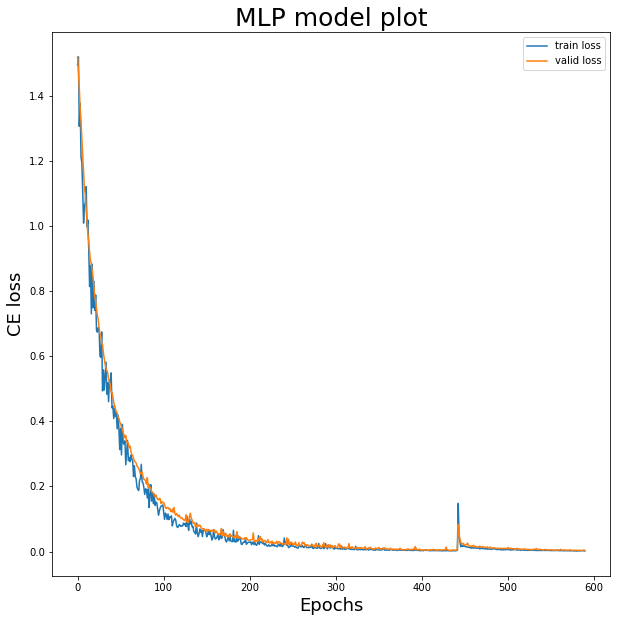

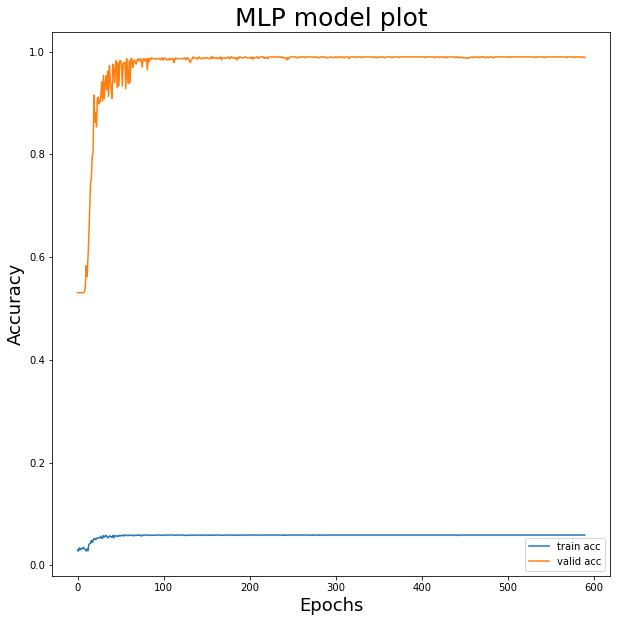

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(tloss_stack, label='train loss')
plt.plot(vloss_stack, label='valid loss')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('CE loss',fontsize=18)
plt.title('MLP model plot', fontsize=25)
plt.legend()
plt.savefig(f'./results/{filter_ths}_loss_LSTM.jpg')

plt.figure(figsize=(10,10))
plt.plot(t_acc_stack, label='train acc')
plt.plot(v_acc_stack, label='valid acc')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
plt.title('MLP model plot', fontsize=25)
plt.legend()
plt.savefig(f'./results/{filter_ths}_accuracy_LSTM.jpg')

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
model = torch.load(f'./LSTM_saved_model_{filter_ths}.pth') 
model.eval()

RNN(
  (rnn): LSTM(56529, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=7, bias=True)
)

In [10]:
y_pred = []
y_true = [] 
for step, (b_x, b_y) in enumerate(valid_loader):
    if torch.cuda.is_available():
        b_x, b_y= (torch.unsqueeze(b_x, 1)).data.type(torch.FloatTensor).cuda(), b_y.cuda()
    r_out = rnn(b_x.cpu())
    _, preds = torch.max(r_out, 1) 
    y_pred.extend(preds.view(-1).detach().cpu().numpy())    
    y_true.extend(b_y.view(-1).detach().cpu().numpy())  

RuntimeError: CUDA out of memory. Tried to allocate 134.00 MiB (GPU 0; 10.92 GiB total capacity; 8.85 GiB already allocated; 101.69 MiB free; 518.00 MiB cached)

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred, normalize='pred') 
per_cls_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=0)
print(per_cls_acc)
df_cm = pd.DataFrame(cf_matrix, test_class, test_class)
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True, cmap='gist_heat_r')
plt.xlabel("prediction", fontsize =15)
plt.ylabel("label (ground truth)", fontsize =15)
plt.title(f'class num >{filter_ths}', fontsize=22)
plt.savefig(f'./results/{filter_ths}_CM_LSTM.jpg')